In [ ]:
print('Connect to google drive')
from google.colab import drive
drive.mount('/gdrive')

Connect to google drive
Mounted at /gdrive


In [ ]:
print('Import necessary libraries')

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import glob
import pickle

import warnings
warnings.filterwarnings("ignore")

import random
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import gc
import tqdm

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

import joblib
import lightgbm as lgb


Import necessary libraries


In [ ]:
base_path='/gdrive/My Drive/Colab Notebooks/'
weights_path='/gdrive/My Drive/Colab Notebooks/weights/'

In [ ]:
def euclidean_distance(x_true,y_true, x_pred, y_pred):
    return np.mean(((x_true-x_pred)**2+(y_true-y_pred)**2)**0.5)    

In [ ]:
version='version1'


In [ ]:
data=pd.read_csv('/gdrive/My Drive/Colab Notebooks/train.zip') #
data.shape

(8650, 315)

In [ ]:
data.head()

,rsid1,rsid2,rsid3,rsid4,rsid5,rsid6,rsid7,rsid8,rsid9,rsid10,rsid11,rsid12,rsid13,rsid14,rsid15,rsid16,rsid17,rsid18,rsid19,rsid20,rsid21,rsid22,rsid23,rsid24,rsid25,rsid26,rsid27,rsid28,rsid29,rsid30,rsid31,rsid32,rsid33,rsid34,rsid35,rsid36,rsid37,rsid38,rsid39,rsid40,...,rsid276,rsid277,rsid278,rsid279,rsid280,rsid281,rsid282,rsid283,rsid284,rsid285,rsid286,rsid287,rsid288,rsid289,rsid290,rsid291,rsid292,rsid293,rsid294,rsid295,rsid296,rsid297,rsid298,rsid299,rsid300,rsid301,rsid302,rsid303,rsid304,rsid305,rsid306,rsid307,rsid308,rsid309,rsid310,rsid311,rsid312,x,y,path-timestamp
0,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-80,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,record_2021_10_11_07_41_02-1633934464983
1,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-80,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,record_2021_10_11_07_41_02-1633934467125
2,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,record_2021_10_11_07_41_02-1633934469251
3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,record_2021_10_11_07_41_02-1633934471370
4,-78,-999,-999,-95,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-50,-51,-51,-43,-49,-47,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-87,-87,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,40.85,25.74,record_2021_10_11_07_41_02-1633934473508


In [ ]:
print('split path-timestamp in 2 columns')
data[['path','timestamp']]=data['path-timestamp'].str.split('-',expand=True)
print('remove path-timestamp column')
data.drop('path-timestamp', axis=1,inplace=True)

split path-timestamp in 2 columns
remove path-timestamp column


In [ ]:
data.head()

,rsid1,rsid2,rsid3,rsid4,rsid5,rsid6,rsid7,rsid8,rsid9,rsid10,rsid11,rsid12,rsid13,rsid14,rsid15,rsid16,rsid17,rsid18,rsid19,rsid20,rsid21,rsid22,rsid23,rsid24,rsid25,rsid26,rsid27,rsid28,rsid29,rsid30,rsid31,rsid32,rsid33,rsid34,rsid35,rsid36,rsid37,rsid38,rsid39,rsid40,...,rsid277,rsid278,rsid279,rsid280,rsid281,rsid282,rsid283,rsid284,rsid285,rsid286,rsid287,rsid288,rsid289,rsid290,rsid291,rsid292,rsid293,rsid294,rsid295,rsid296,rsid297,rsid298,rsid299,rsid300,rsid301,rsid302,rsid303,rsid304,rsid305,rsid306,rsid307,rsid308,rsid309,rsid310,rsid311,rsid312,x,y,path,timestamp
0,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,record_2021_10_11_07_41_02,1633934464983
1,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,record_2021_10_11_07_41_02,1633934467125
2,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,record_2021_10_11_07_41_02,1633934469251
3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,record_2021_10_11_07_41_02,1633934471370
4,-78,-999,-999,-95,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-50,-51,-51,-43,-49,-47,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-87,-87,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,40.85,25.74,record_2021_10_11_07_41_02,1633934473508


In [ ]:
TRAIN_FEATS=[x for x in data.columns if x not in ['x', 'y', 'path', 'timestamp']]
len(TRAIN_FEATS)

312

In [ ]:
unpaths=data.path.unique()

In [ ]:
print('we have ',len(unpaths),' unique paths')

we have  254  unique paths


### CV TRAIN

In [ ]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 15000
}


In [ ]:
# CROSS VALIDATION

name='lgbm'+version


score_df = pd.DataFrame()
oof = list()
predictions = list()

oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
preds_x, preds_y = 0, 0

scores_per_fold=[]

all_preds=[]
all_targets=[]

np.random.seed(42)
sh=np.random.permutation(unpaths)


k=5
val_size=int(len(sh)/k)
for f in range(k):
    print('fold:', f)

    if f<(k-1):
        val_paths=sh[val_size*f:val_size*(f+1)]
    else:
        val_paths=sh[val_size*f:]

    train_paths=[x for x in unpaths if x not in val_paths]
    
    val_paths=np.array(val_paths)
    train_paths=np.array(train_paths)
    
    X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

    y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

    X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
    y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values

    val_predsXY=[]
    for i in range(2):
        y_train = y_trainXY[:,i]
        y_val = y_valXY[:,i]

        gbm = lgb.LGBMRegressor(**hyper_params)
        model = gbm.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_metric='l1',
            verbose=100,
            early_stopping_rounds=200)
        
        joblib.dump(model, weights_path+'fold_'+str(f)+['x','y'][i]+'_v2')
        
        val_predsXY.append(gbm.predict(X_val, num_iteration=gbm.best_iteration_) )
    val_predsXY=np.stack(val_predsXY).T
    
    print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

    all_preds.append(val_predsXY)
    all_targets.append(y_valXY)
        

all_predsV=np.vstack(all_preds)
all_targetsV=np.vstack(all_targets)    

fold: 0
Training until validation scores don't improve for 200 rounds.
[100]	training's l2: 35.4113	training's l1: 4.45692	valid_1's l2: 48.5269	valid_1's l1: 5.49193
[200]	training's l2: 15.4195	training's l1: 3.01614	valid_1's l2: 21.3927	valid_1's l1: 3.68359
[300]	training's l2: 7.59687	training's l1: 2.13491	valid_1's l2: 10.9987	valid_1's l1: 2.6138
[400]	training's l2: 4.4426	training's l1: 1.61533	valid_1's l2: 6.96888	valid_1's l1: 2.02245
[500]	training's l2: 3.09347	training's l1: 1.31609	valid_1's l2: 5.35664	valid_1's l1: 1.71259
[600]	training's l2: 2.45022	training's l1: 1.14615	valid_1's l2: 4.68292	valid_1's l1: 1.56212
[700]	training's l2: 2.10384	training's l1: 1.04763	valid_1's l2: 4.37294	valid_1's l1: 1.48675
[800]	training's l2: 1.91437	training's l1: 0.993559	valid_1's l2: 4.21409	valid_1's l1: 1.45173
[900]	training's l2: 1.78171	training's l1: 0.954956	valid_1's l2: 4.12752	valid_1's l1: 1.43412
[1000]	training's l2: 1.70587	training's l1: 0.934498	valid_1's l

In [ ]:
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

mean validation error, 5-fold 2.182140519041445


In [ ]:
pd.DataFrame(all_predsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/lgbm_oof.csv.gz', index=False, compression='gzip')
pd.DataFrame(all_targetsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/all_targetsV.csv.gz', index=False, compression='gzip')

## EVALUATION - PLOTS

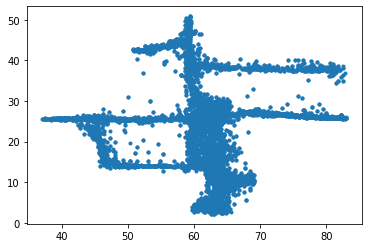

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_predsV[:,0],all_predsV[:,1],'.')
plt.show()

**5 FOLD CV PREDICTIONS OVER TARGET GRID**  
With blue dots are the true checkpoints  
Orange dots for predictions

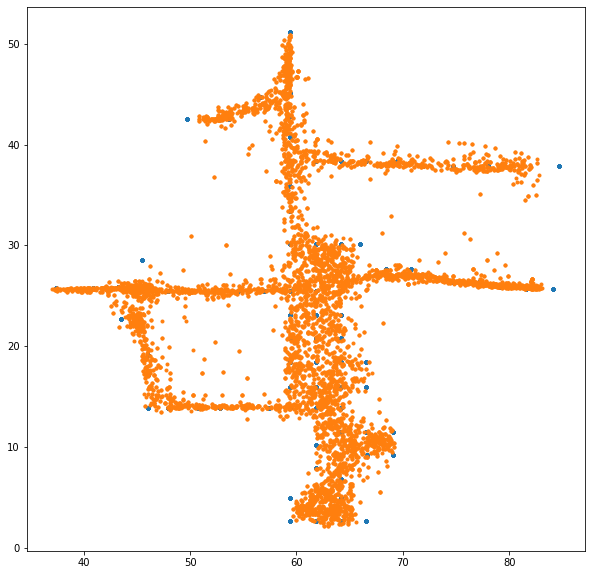

mean validation error, 5-fold 2.182140519041445


In [ ]:
plt.figure(figsize=(10,10))
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'.')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

## Full train

In [ ]:
hyper_params["num_iterations"]= 2000

In [ ]:


name=version+'KNeighbors'

train_paths=unpaths[:]

train_paths=np.array(train_paths)

X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

train_predsXY=[]
all_train_targets=[]
for i in range(2):
    y_train = y_trainXY[:,i]

    gbm = lgb.LGBMRegressor(**hyper_params)


    model = gbm.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
        eval_metric='l1',
        verbose=100
        )
    
    joblib.dump(model, weights_path+'FullTrain_'+['x','y'][i])
    
    train_predsXY.append(gbm.predict(X_train, num_iteration=gbm.best_iteration_) )

train_predsXY=np.stack(train_predsXY).T

print('train error',euclidean_distance(train_predsXY[:,0], train_predsXY[:,1], y_trainXY[:,0], y_trainXY[:,1]))


[100]	training's l2: 38.3345	training's l1: 4.71696
[200]	training's l2: 16.602	training's l1: 3.18283
[300]	training's l2: 8.0519	training's l1: 2.22868
[400]	training's l2: 4.60573	training's l1: 1.65996
[500]	training's l2: 3.1466	training's l1: 1.34015
[600]	training's l2: 2.47817	training's l1: 1.16075
[700]	training's l2: 2.13499	training's l1: 1.06318
[800]	training's l2: 1.93316	training's l1: 1.00606
[900]	training's l2: 1.79934	training's l1: 0.96694
[1000]	training's l2: 1.71548	training's l1: 0.942088
[1100]	training's l2: 1.65718	training's l1: 0.925096
[1200]	training's l2: 1.61548	training's l1: 0.913741
[1300]	training's l2: 1.58497	training's l1: 0.904689
[1400]	training's l2: 1.55963	training's l1: 0.897377
[1500]	training's l2: 1.53172	training's l1: 0.889893
[1600]	training's l2: 1.49979	training's l1: 0.879638
[1700]	training's l2: 1.47552	training's l1: 0.871552
[1800]	training's l2: 1.45342	training's l1: 0.865073
[1900]	training's l2: 1.43552	training's l1: 0.86

In [ ]:
print('Save LightGBM model fully trained')
joblib.dump(model,'/gdrive/My Drive/Colab Notebooks/weights/lgbm_model')

Save LightGBM model fully trained


['/gdrive/My Drive/Colab Notebooks/weights/lgbm_model']